# Understanding the dynamic of the Covid19 pandemic


You can find this notebook [here](https://github.com/madlag/coronavirus_study/tree/master/notebooks).

Hi, I am [__François Lagunas__](http://madl.ag).

This notebook is intended to **explore the hypothesis that an immunity was reached in the most impacted countries**, because the number of people that were contaminated, and allegedly immune to the virus, is large enough to prevent the pandemic to propagate further in the population.

This is a classic case of epidemiology.

The **curve** that describe the cumulative number of persons that are infected is called a **logistic**.

You can find a very good explanation of how pandemics work, and how the logistic function is involved, in this [3blue1brown youtube video](https://youtu.be/Kas0tIxDvrg?t=292) .

So here we will see if actual numbers really fit a logistic curve, for some various countries.

Let's write a few helper functions first.

In [50]:
import numpy
import math
import matplotlib
import matplotlib.pyplot as plt

def points(fun, start = -5, end = 5, step = 0.01):
    r = [x for x in numpy.arange(start, end + step, step)]
    return r, list(map(fun, r))
    
def plot_fun(funs, figure = True, legend = True, start = -7, end = 7, step = 0.01, log_scale = False):
    if figure:
        fig=plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    if not isinstance(funs, list):
        funs = [funs]
    for fun in funs:
        r, pts = points(fun, start = start, end = end, step = step)
        plt.plot(r, pts, label=fun.__name__)
    if log_scale:
        plt.yscale("log")
    if legend:
        _ = plt.legend()

def g(x):
    return 1 / (1 + math.exp(-x))

def logistic(x):
    return g(x)

# from https://calculus.subwiki.org/wiki/Logistic_function#First_derivative
def logistic_derivative(x):
    return g(x) * (1 - g(x))
    
# from https://calculus.subwiki.org/wiki/Logistic_function#Second_derivative
# Just for your information, not used here
def logistic_2nd_derivative(x):
    return g(x) * g(-x) * (g(-x) - g(x))



# Cumulated deaths or cases : the logistic function

As we said, in a "perfect" epidemic which propagates freely until enough people are immune, the curve of cumulated deaths follows a logistic function.
It looks like this:

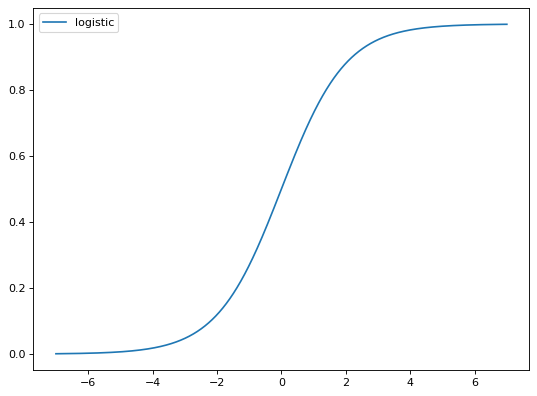

In [51]:
plot_fun(logistic)

# Daily numbers

The curve of daily casualties is then the **derivative of the first curve**.

It looks like this :

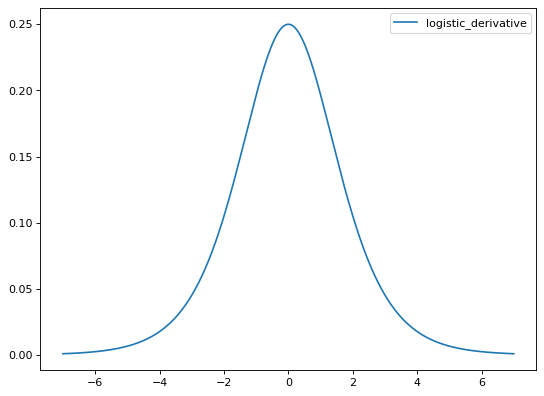

In [52]:
plot_fun(logistic_derivative)

What is important is that this curve is **symmetrical** relative to its peak.

What about the **log** of this curve ?

For epidemics, **log scale** is often a good way to look at things.
And we add a **linear approximation** to better visualize the slope of the curve.

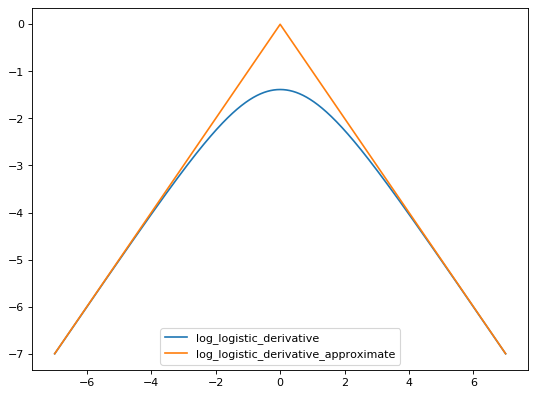

In [53]:
def log_logistic(x):
    return math.log(logistic(x))

# from https://calculus.subwiki.org/wiki/Logistic_function#First_derivative
def log_logistic_derivative(x):
    return math.log(logistic_derivative(x))

# from https://calculus.subwiki.org/wiki/Logistic_function#Second_derivative
# Just for your information, not used here
def log_logistic_2nd_derivative(x):
    return math.log(abs(logistic_2nd_derivative(x)))

def log_logistic_derivative_approximate(x):
    return - abs(x)
    

plot_fun([log_logistic_derivative, log_logistic_derivative_approximate])

Of course this curve is **symmetrical** too.

What is more interesting, is that it looks very **linear before AND after the peak**. And the **slope is the same**.

That's because at the very **beginning**, the epidemic is **exponential**, so its log is a straight line,

And at the **end** it's **exponential** too, but with a **negative time coefficient** (see the video mentionned in the intro).


So now, let's have a look at **real world curves, for daily deaths, with log scale**.

The code is available in the same github repository, http://madl.ag/coronavirus_study/ , and the graphs are built from ECDC data.


In [54]:
from tools import MultiCountryGraph, DataProvider, CountryInfoStore

data_provider = DataProvider()

country_info_store = CountryInfoStore(data_provider, debug = False)

data_date = data_provider.data_date
    
main_chart_countries = ["Germany", "France", "Italy", "United_States_Of_America"]
data_type = "day_deaths"

if "day" in data_type:
    average_data_length = 7
    growth_reference = False
else:
    average_data_length = 1
    growth_reference = True            

2020-07-05


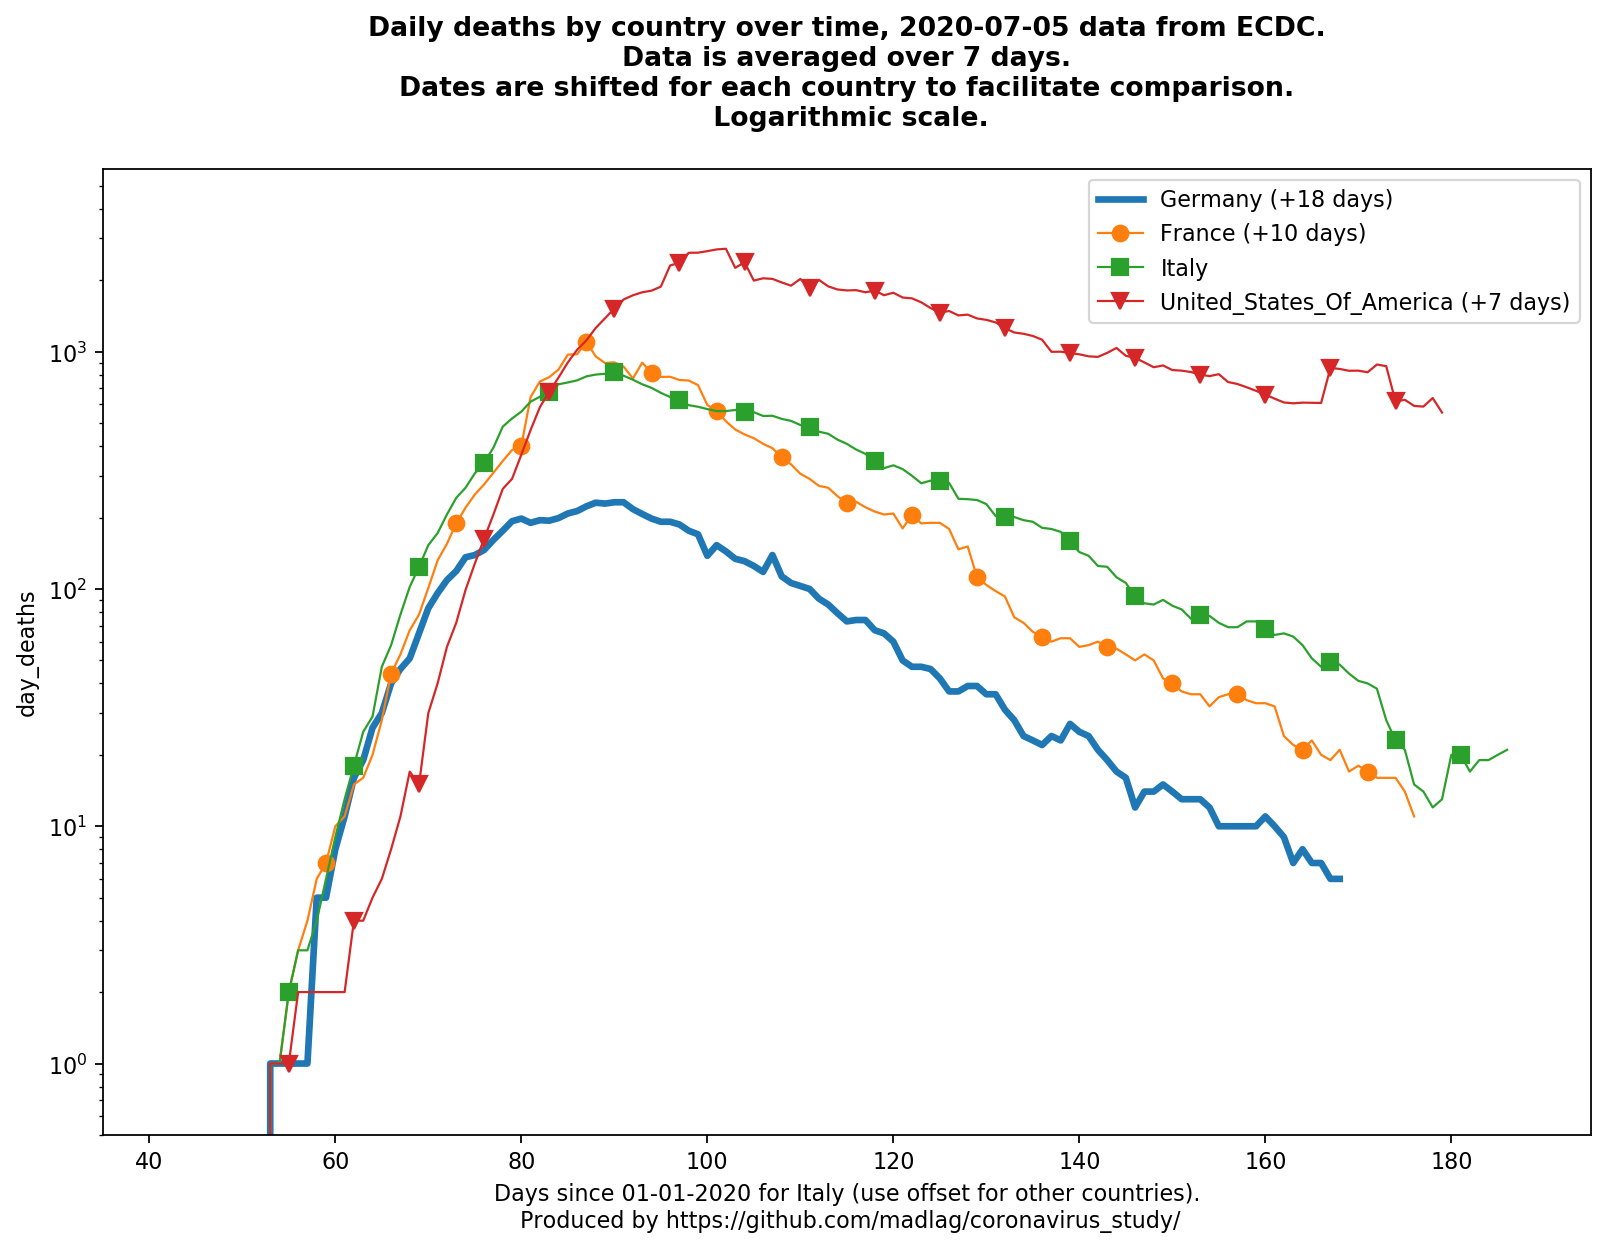

In [55]:
g = MultiCountryGraph(data_provider,
                      country_info_store,
                      main_chart_countries,
                      log_axis = True,
                      data_type = data_type,
                      visually_impaired = True,
                      china_comparison = False,
                      growth_reference=growth_reference,
                      average_data_length=average_data_length)

g.plot_()

## Observations
Do we observe the same kind of curve ? I am afraid we are not.

We still have a first quasi linear part, and a final one. But the slopes are very different: the curve is absolutely not symmetrical relative to its peak.

Let's now fit the right parameters to fit the curve

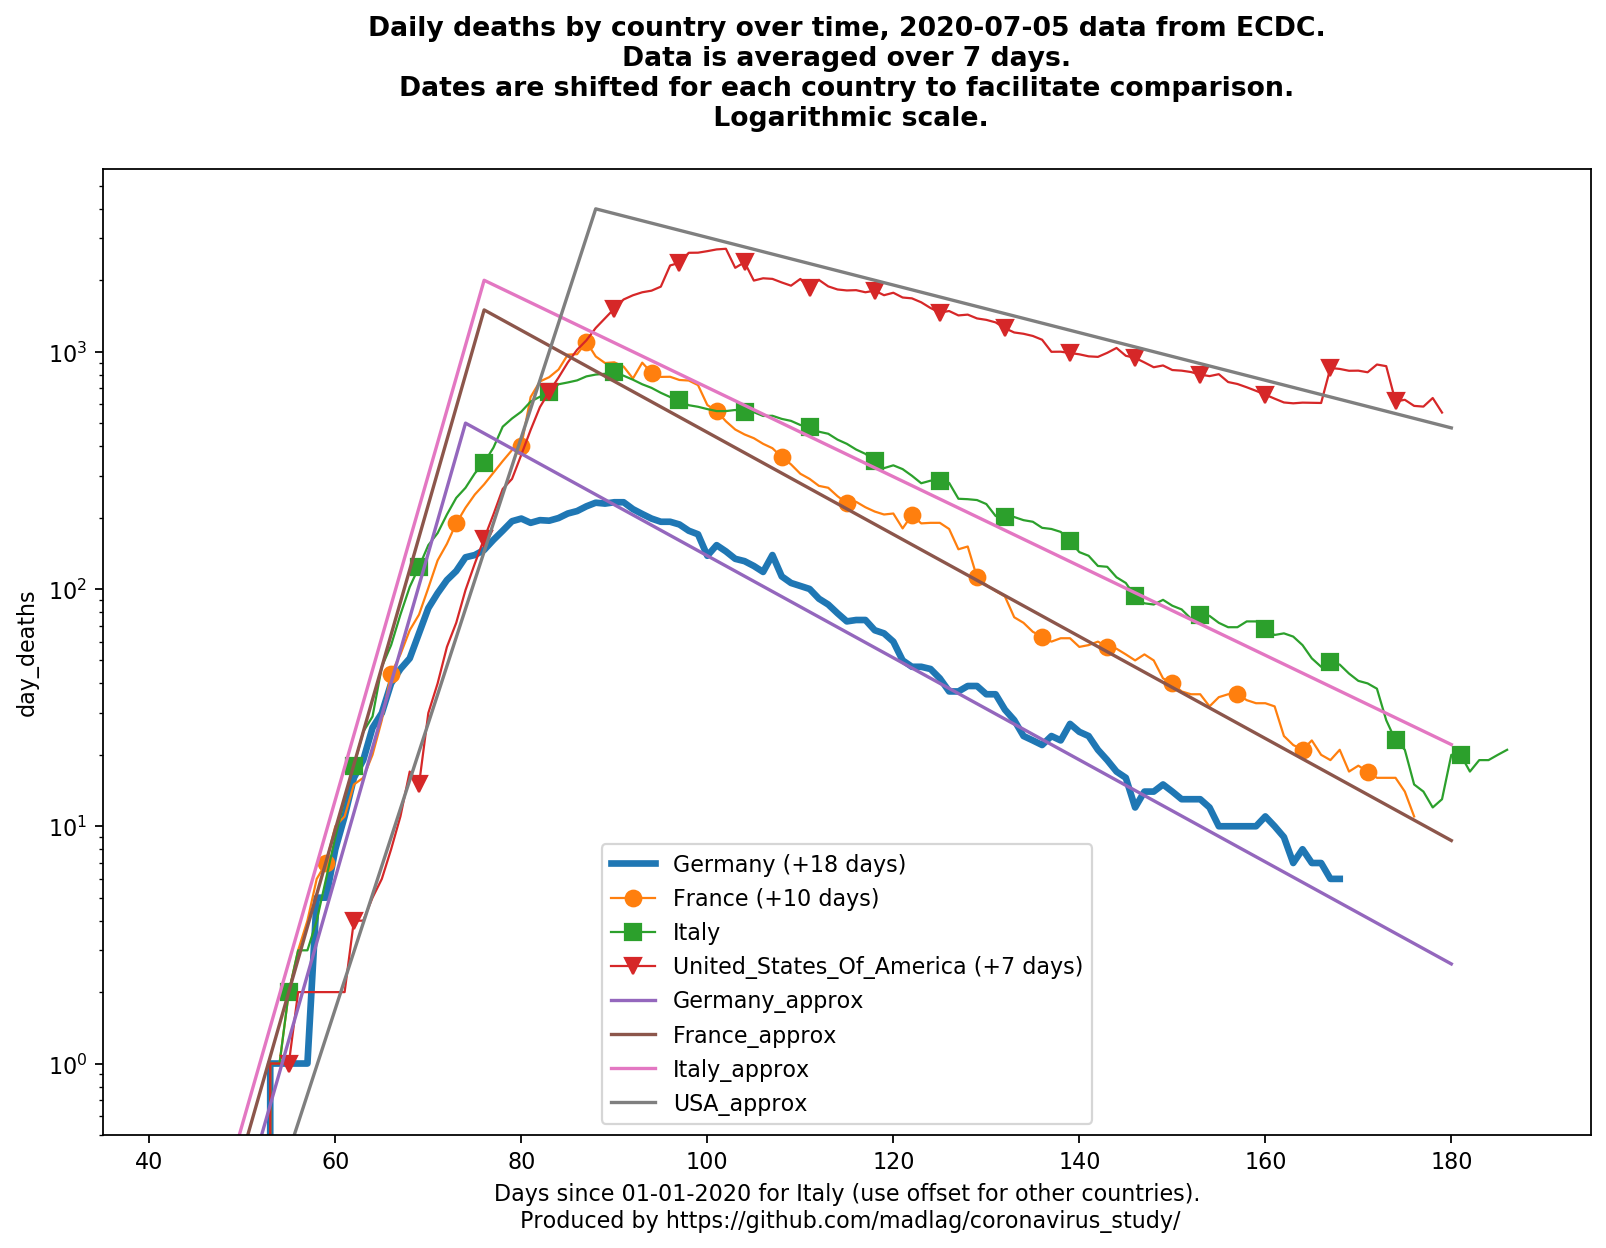

In [46]:

# from https://calculus.subwiki.org/wiki/Logistic_function#First_derivative
def approx(x, time_scale_0 = 2.2, time_scale_1 = 14, time_offset = 76, z_offset = None):
    if x < time_offset:
        return math.pow(2, (x - time_offset) / time_scale_0) * z_offset
    else:
        return math.pow(2, -(x - time_offset) / time_scale_1) * z_offset
        
def Germany_approx(x):
    return approx(x, time_offset = 74, z_offset = 500)

def France_approx(x):
    return approx(x, z_offset = 1500)

def Italy_approx(x):
    return approx(x, time_scale_1 = 16, z_offset = 2000)

def USA_approx(x):
    return approx(x, time_scale_0 = 2.5, time_scale_1 = 30, time_offset = 88, z_offset = 4000)

def add_approx(figure = False, log_scale = False):
    plot_fun([Germany_approx, France_approx, Italy_approx, USA_approx], 
             figure = figure,
             legend = False,
             start = 40, end = 180, step = 1, log_scale = log_scale)

                        

g = MultiCountryGraph(data_provider,
                      country_info_store,
                      main_chart_countries,
                      log_axis = True,
                      data_type = data_type,
                      visually_impaired = True,
                      china_comparison = False,
                      growth_reference=growth_reference,
                      average_data_length=average_data_length)

g.plot_(callback = add_approx)


The fit looks quite good to me.

The important values that we will be using later are the **slopes of the curve before and after the peak**, and the related **doubling and halving times** (the time it takes to double the number of cases/deaths, and after the peak the time it takes to halve the number of cases / deaths).

**Doubling time:**

France, Germany and Italy: 2.2 days 

USA : 2.5 days 

**Halving times:**

France, Germany: 14 days 

Italy : 16 days

USA : 30 days 

Indeed, the **slopes are very different before and after the peak, not equals like in a logistic trajectory.**

Let's remove the true data to have a better view:

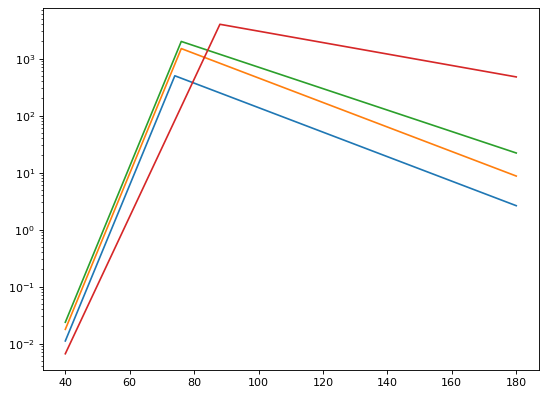

In [47]:
add_approx(figure = True, log_scale = True)

Just to better understand what is happening, here is the synthetic data without the log scale:

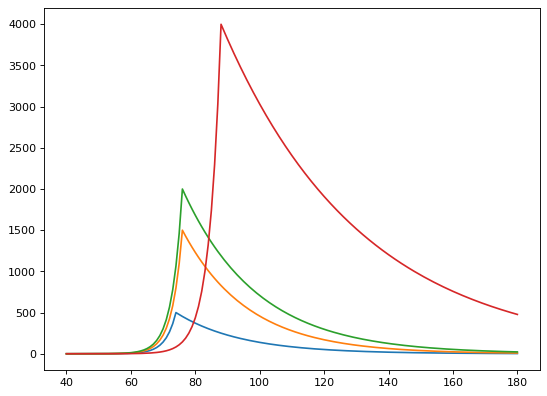

In [48]:
add_approx(figure = True, log_scale = False)

This does not look at all like a logistic derivative, it's way too asymmetrical.

## Interpretation

So how can we interpret this ?
The best explanation to me is that **we are not seeing the effect of the immunity kicking in.**

We are seeing the effects of the containment measures, lockdown, masks etc.

Because if the immunity was helping us getting us rid of the covid19, **the slope would be even steeper in the second part than in the first, not the contrary**: adding immunity to containment measures would make it disappear even faster.

We are still battling the covid19 propagation with only very limited help from some immunity.

## How can we quantify this propagation speed ?

We have all heard of the R0 of the covid19. It's not used in a correct way, as it should be just used for talking about the very beginning of the epidemics, when no measure are taken. It's the natural rate of propagation of the illness.

The $R_e$ is the correct name to talk about the propagation after some measures are changing the propagation. It's the R effective, and it's a function of t, as human behaviour change, immunity kicks in etc.

$R_0$ is related to the doubling time 

How can we quantify $R_e$ ?

It's a bit technical, but here we go:

**${R_0}$ definition** : during a given period T, a sick person propagates the virus to $R_0$ persons.

The epidemic follows an exponential curve:

$e^{T.c} = R_0$ where c is a constant

$T = \frac{ln(R_0)}{c}$

Definition of the time scale $t_0$:

$e^{t_0 * c} = 2$

$c = ln(2) / t_0$

$T = \frac{ln(R_0) * t_0}{ln(2)}$


**$R_e$ definition**: during the same given period T, a sick person propagates the virus to $R_e$ persons

We get the same formula, with a different time scale $t_1$ (with is negative, because the slope is):

$T = \frac{ln(R_e) * t_1}{ln(2)}$

So :

$\frac{ln(R_e) * t_1}{ln(2)} = T = \frac{ln(R_0) * t_0}{ln(2)}$

$ln(R_e) = ln(R_0) * \frac{t_0}{t_1}$

**So finally we simply get:**

$R_e = R_0^{t_0 / t_1}$

## Sanity check

If we look at this formula, we find that
- if $t_1 = t_0$, we indeed have $R_e = R_0$
- if the slope is negative, $t_1 < 0$,  $R_e < 1$, we have a reduction in the number of cases
- if $t_1$ tends to infinity (we get a flat curve after the peak), we have indeed a $R_e$ of 1.

## Numerical results
Finally, let's plug the time scales we got from fitting the real data:


In [49]:
def Reff(R0, time_scale0, time_scale1):
    Re = pow(R0, time_scale0 / time_scale1)
    return Re

def print_reff(time_scale0, time_scale1, label):
    Re = Reff(3, time_scale0, time_scale1)
    print(label + ": Re=%0.2f" % Re)

print_reff(2.2, -14, "Germany and France")
print_reff(2.2, -16, "Italy")
print_reff(2.5, -30, "USA")

print_reff(2.5, -2.5, "Logistics baseline")

Germany and France: Re=0.84
Italy: Re=0.86
USA: Re=0.91
Logistics baseline: Re=0.33


**We see that the $R_e$ is below 1, indeed, but barely : a logistic evolution would have $t_0 = t_1$, and lead to a $R_e$ of 0.33.**

You should keep in mind that getting a $R_e=1$ means that the pandemics is propagating at a constant rate, >1 growing exponentially, and <1 slowing down. You want it the lower you can. 

It look like we are far of a immunity-driven evolution, but we already saw it according to the fairly asymmetrical character of the curves we fitted.

**$R_e$ is still way too high to conclude that the immunity is responsible for the decrease.**

# Conclusion

This may look a bit technical, but it is not really for someone who have done some college level maths.

**We have tested the logistic hypothesis with real data**, and we are **far from convinced that a logistic function really fit correctly the data.**

If you look at the **cumulated deaths** or cases, yes, an epidemic always **looks like a logistic function**.

But if you look at the first derivative aka the **daily numbers**, it becomes evident that it's **not fitting at all**.

Last, but not least, we should be careful with aggregated numbers. We considered whole countries here, but the local situation can be very different from place to place. It does not really change our conclusions in our specific case, but mixing places with very different $R_e$ can give unsound results.

Delays in data can lead to serious errors to, especially if you are in the peak period, where nothing is really clearly defined, especially the slope of the curve.

